In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
from matplotlib.ticker import MaxNLocator
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def preprocessing():
    df = pd.read_csv("goodreads_scraping_final.csv")
    
    # delete unnecessary columns
    df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)

    df.rename(columns={'name':'Title', 'Dates':'Publishdate', 'author':'Author', 'Verify_pages': 'Num_pages'}, inplace=True)
    
    df.index.names = ["ID"]
    
    # cleaning the Title
    df['Title'] = df['Title'].str.strip()
        
    # Calculating number of awards
    df['Awards'] = df['Awards'].str.strip('[]').replace(r'^\s*$', np.NaN, regex=True)
    df['Awards_x'] = df.Awards.str.split(',')
    df['award_count'] = df['Awards_x'].str.len()
    df['award_count'] = df['award_count'].fillna(0).astype(int)
    df = df.drop(['Awards_x'], axis= 1)
    
    # cleaning SeriesName
    df['SeriesName'] = df.SeriesName.str.replace('(Series)', '').str.replace('(\n)', '')
    
    # cleaning ISBN
    df['ISBN'] = df.ISBN.str.replace(r"(ISBN13:)", '').str.strip(' ()')
    
    # cleaning setting column
    df['Setting'] = df['Setting'].str.strip('[]')

    # Cleaning author column from paranthesis text
    df['Author'] = df.Author.str.replace(r" \(.*Goodreads Author\)","")

    # cleaning number of ratings
    df.rename(columns={'number of ratings': 'number_of_ratings'}, inplace=True)
    df['number_of_ratings'] = df['number_of_ratings'].str.replace('[,]',"").str.replace('[^0-9]',"0").fillna(0).astype(int)

    # cleaning avg_rat
    df['avg_ratings'] = df.avg_ratings.str.replace('[^0-9.]',"")
    df.loc[df['avg_ratings'] == '.', 'avg_ratings'] = np.NaN
    df['avg_ratings'] = df['avg_ratings'].replace(r'^\s*$', np.NaN, regex=True).astype(float)
    
    # cleaning Genre
    df['Genre'] = df['Genre'].str.strip('[]')
    
    # cleaning pages
    df['Num_pages'] = df['Num_pages'].astype(str)
    df['Num_pages'] = df.Num_pages.str.replace('[^0-9]',"")
    for i in df.index:
        if len(df.iloc[i]['Num_pages']) >= 5 or len(df.iloc[i]['Num_pages']) <= 1:
            df.at[i, 'Num_pages'] = np.NaN
    df['Num_pages'] = df['Num_pages'].replace(r'^\s*$', np.NaN, regex=True)
    df['Num_pages'] = pd.to_numeric(df['Num_pages'])
    
    # cleaning publish year
    df.rename(columns={' Publishdate': 'Publishdate'}, inplace=True)
    df['Publishdate'] = df.Publishdate.str.replace('[^0-9-]',"")
    df['original_publish_year'] = df['Publishdate'].replace(r'^\s*$', np.NaN, regex=True).str[-4:]
    df = df.drop(['Publishdate'], axis= 1)
    
    # Calculating normalized ratings
    df['minmax_norm_ratings'] = 1 + (df['avg_ratings'] - df.avg_ratings.min()) / (df.avg_ratings.max()-df.avg_ratings.min()) *9
    df['mean_norm_ratings'] = 1 + ((df['avg_ratings'] - df.avg_ratings.mean()) / (df.avg_ratings.max()-df.avg_ratings.min())) *9

    # delete last 7 rows    
    #df.drop(df.tail(7).index, inplace = True) 

    # Just for CSV to show data
    #df.rename(columns={'url': 'URL', 'avg_ratings':'Average rating', 'original_publish_year':'Publishingdate', 'number_of_ratings':'Number of ratings', 'Num_pages': 'Number of pages', 'award_count': 'Number of awards'}, inplace=True)
    #df.to_csv('Data_Show.csv')
    
    dm = pd.read_csv('data_map.csv')
    dm = dm['map_url']
    
    dc = pd.read_csv('data_cover.csv')
    dc = dc['cover_url']
    
    df = df.join(dm)
    df = df.join(dc)
    
    df.to_csv('data_final.csv')
    return df

preprocessing()

,Title,Author,number_of_ratings,url,avg_ratings,Num_pages,Awards,Genre,Setting,Series,SeriesName,ISBN,Description,award_count,original_publish_year,minmax_norm_ratings,mean_norm_ratings,map_url,cover_url
ID,,,,,,,,,,,,,,,,,,,
0,"A Game of Thrones (A Song of Ice and Fire, #1)",George R.R. Martin,2049108,https://www.goodreads.com//book/show/13496.A_G...,4.45,835.0,"'Nebula Award Nominee for Best Novel (1997)', ...","'Fantasy', 'Fiction', 'Fantasy', 'Epic Fantasy...",'The Lands of Ice and Fire',True,A Song of Ice and Fire #1,9780553588484,Here is the first volume in George R. R. Marti...,4,1996,8.088496,2.407440,https://i2.wp.com/www.fantasticmaps.com/wp-con...,https://images-na.ssl-images-amazon.com/images...
1,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,112537,https://www.goodreads.com//book/show/30.J_R_R_...,4.60,1728.0,NaN,"'Fantasy', 'Fiction', 'Classics', 'Adventure',...",'Middle-earth',True,"The Lord of the Rings #0-3, Middle-earth Unive...",9780345538376,"This four-volume, boxed set contains J.R.R. To...",0,1955,8.685841,3.004785,https://api-v3.twenty20.com/items/6e1a6b11-aa9...,https://images-na.ssl-images-amazon.com/images...
2,The Name of the Wind (The Kingkiller Chronicle...,Patrick Rothfuss,740343,https://www.goodreads.com//book/show/186074.Th...,4.52,662.0,'Locus Award Nominee for Best First Novel and ...,"'Fantasy', 'Fiction', 'Fantasy', 'Epic Fantasy...",,True,The Kingkiller Chronicle #1,9780756404079,"Told in Kvothe's own voice, this is the tale o...",8,2007,8.367257,2.686201,https://i.pinimg.com/originals/1d/a7/61/1da761...,https://images-na.ssl-images-amazon.com/images...
3,"The Way of Kings (The Stormlight Archive, #1)",Brandon Sanderson,320338,https://www.goodreads.com//book/show/7235533-t...,4.62,1007.0,'Locus Award Nominee for Best Fantasy Novel (2...,"'Fantasy', 'Fiction', 'Fantasy', 'Epic Fantasy...",'Roshar',True,"The Stormlight Archive #1, The Cosmere",9780765326355,From #1 New York Times bestselling author Bran...,4,2010,8.765487,3.084431,https://cdna.artstation.com/p/assets/images/im...,https://images-na.ssl-images-amazon.com/images...
4,The Chronicles of Narnia (Chronicles of Narnia...,C.S. Lewis,533551,https://www.goodreads.com//book/show/11127.The...,4.26,767.0,NaN,"'Fantasy', 'Classics', 'Fiction', 'Young Adult...","'London, England'",True,The Chronicles of Narnia (Publication Order) #...,NaN,"Journeys to the end of the world, fantastic cr...",0,1956,7.331858,1.650803,https://i.pinimg.com/originals/71/ab/ba/71abba...,https://images-na.ssl-images-amazon.com/images...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,"Demon Lord of Karanda (The Malloreon, #3)",David Eddings,42586,https://www.goodreads.com//book/show/286507.De...,4.02,404.0,NaN,"'Fantasy', 'Fiction', 'Fantasy', 'Epic Fantasy...",,True,"The Malloreon #3, Belgariad Universe #10",9780345363312,Captives of His Imperial Majesty...Zandramas h...,0,1988,6.376106,0.695050,https://lh3.googleusercontent.com/proxy/nveIZB...,https://images-na.ssl-images-amazon.com/images...
1096,Dragon of Legend: Destiny: Fantasy Dragon Adve...,Angelika Meyer,133,https://www.goodreads.com//book/show/25975141-...,4.71,420.0,NaN,"'Fantasy', 'Fantasy', 'Magic'",,False,NaN,NaN,"For over a thousand years, the Lands have been...",0,2015,9.123894,3.442838,https://i.pinimg.com/originals/81/a4/17/81a417...,https://images-na.ssl-images-amazon.com/images...
1097,"Oath of Swords (War God, #1)",David Weber,6710,https://www.goodreads.com//book/show/17315.Oat...,4.01,576.0,NaN,"'Fantasy', 'Fiction', 'Fantasy', 'Epic Fantasy...",,True,"War God #1, Schwerter des Zorns #1",9781416520863,"Whom the gods would recruit, they first tick o...",0,1995,6.336283,0.655227,https://i.gr-assets.com/images/S/compressed.ph...,https://m.media-amazon.com/images/I/51we6KVhrx...


In [69]:
# Analyse exercise from day 1

def analyse_highest_book(df, a):
    df_a = df.dropna(subset= ['original_publish_year','minmax_norm_ratings'])
    df_a['original_publish_year'] = df_a['original_publish_year'].astype(int) 
    dp = df_a.groupby(df_a.original_publish_year).agg({'minmax_norm_ratings': np.mean})
    dp = dp.rename(columns={'minmax_norm_ratings': 'minmax_norm_ratings_mean'})
    author_group = df.loc[df['Author'] == a]
    book_max_rating = author_group.iloc[author_group['minmax_norm_ratings'].argmax()]['Title']
        
    print(book_max_rating)
    return dp

print(analyse_highest_book(preprocessing(), 'J.R.R. Tolkien'))

J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings
                       minmax_norm_ratings_mean
original_publish_year                          
-800                                   5.380531
-750                                   5.778761
 181                                   8.606195
 900                                   4.146018
 1010                                  8.367257
...                                         ...
 2016                                  7.357301
 2017                                  7.235988
 2018                                  7.329646
 2019                                  7.530973
 2020                                  8.367257

[89 rows x 1 columns]


<ipython-input-69-1c4639a8c64a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['original_publish_year'] = df_a['original_publish_year'].astype(int)


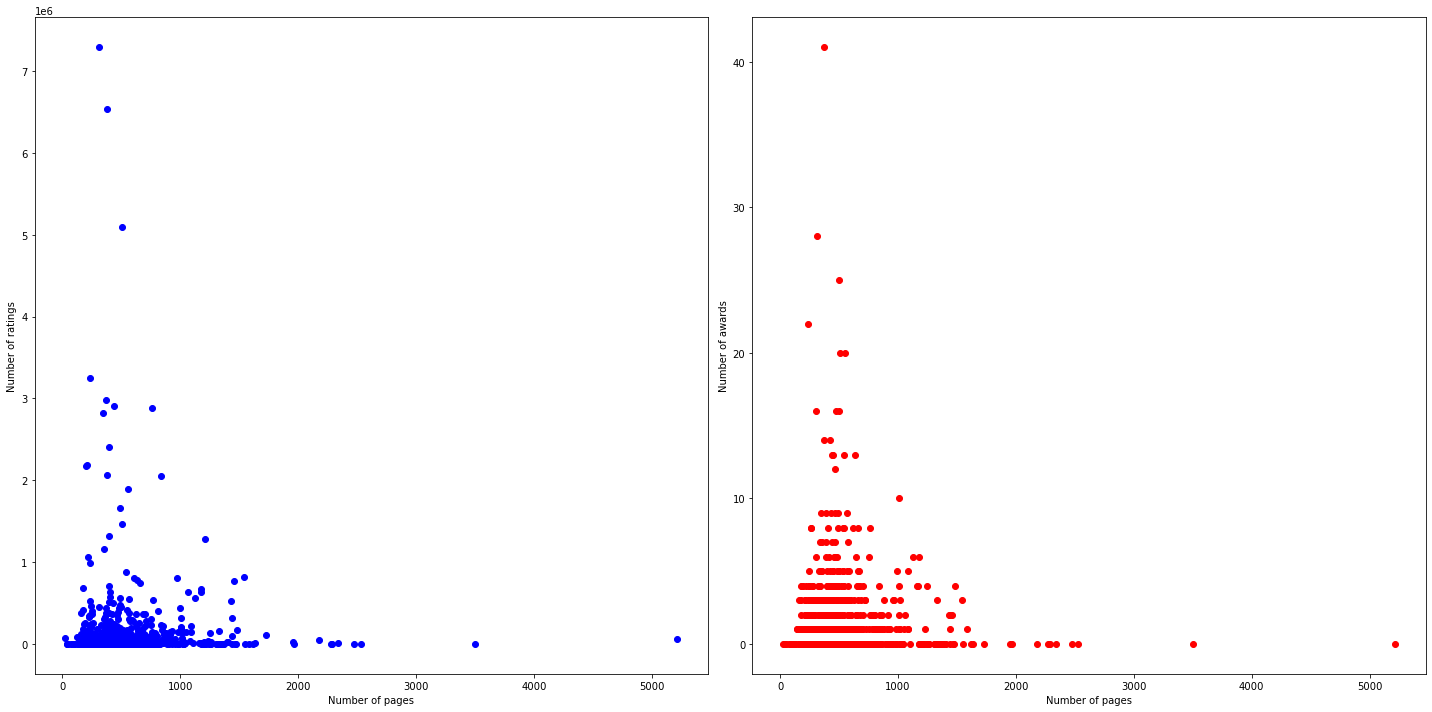

In [62]:
# 1. Create a 2D scatterplot with pages on the x-axis and num_ratings on the y-axis.

df_s = preprocessing()
df_s = df_s.dropna(subset= ['Num_pages','number_of_ratings', 'award_count'])

plt.figure(figsize=(20,10))
x1  = df_s['Num_pages'].astype(int)
x2 = df_s['Num_pages'].astype(int)

y1 = df_s['number_of_ratings'].astype(int)
y2 = df_s['award_count'].astype(int)

plt.subplot(1,2,1)
plt.scatter(x1, y1, color='blue')
plt.xlabel("Number of pages")
plt.ylabel("Number of ratings")

plt.subplot(1,2,2)
plt.scatter(x2, y2, color='red')
plt.xlabel("Number of pages")
plt.ylabel("Number of awards")

plt.tight_layout()
plt.show()

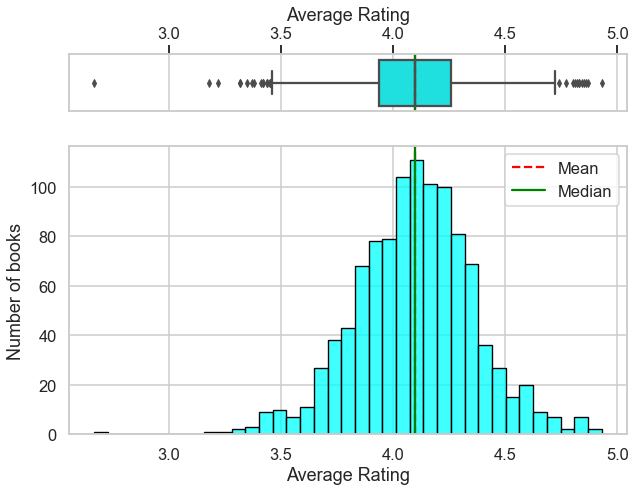

In [70]:
# 3. Visualise the avg_rating distribution.
# boxplot and histogram for average rating

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)}, figsize=(10,7))

mean=preprocessing()['avg_ratings'].mean()
median=preprocessing()['avg_ratings'].median()

sns.boxplot(preprocessing()["avg_ratings"], ax=ax_box, color = 'aqua')
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.xaxis.set_ticks_position('top') 

sns.histplot(preprocessing()["avg_ratings"], ax=ax_hist, color = 'aqua', edgecolor = 'black')
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')

plt.legend({'Mean':mean,'Median':median})

ax_box.set(title= 'Average Rating', xlabel='')
ax_hist.set(xlabel='Average Rating', ylabel='Number of books')
plt.show()

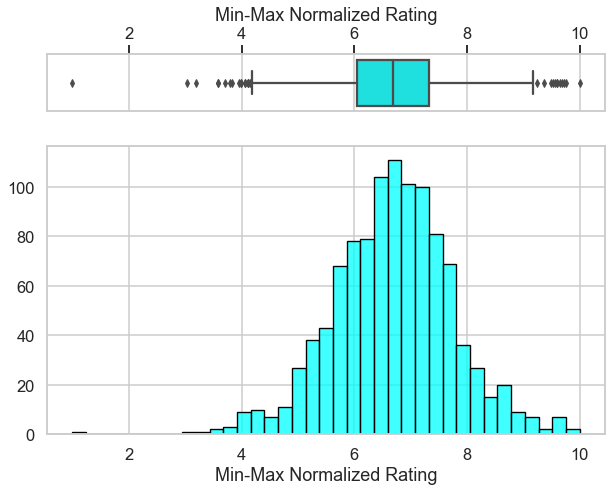

In [71]:
# 4. Visualise the minmax_norm_rating distribution.
#    boxplot and histogram for min-max normalized ratings

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)}, figsize=(10,7))


sns.boxplot(preprocessing()["minmax_norm_ratings"], ax=ax_box, color = 'aqua')
ax_box.xaxis.set_ticks_position('top') 
sns.histplot(preprocessing()["minmax_norm_ratings"], ax=ax_hist, color = 'aqua', edgecolor = 'black')

ax_box.set(title= 'Min-Max Normalized Rating', xlabel='')
ax_hist.set(xlabel='Min-Max Normalized Rating', ylabel='')
plt.show()

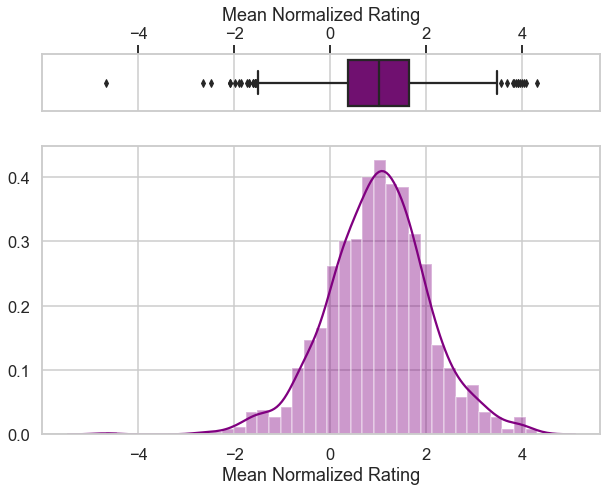

In [72]:
# 5. Visualise the mean_norm_rating distribution.
#    boxplot and histogram for mean normalized ratings

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)}, figsize=(10,7))


sns.boxplot(preprocessing()["mean_norm_ratings"], ax=ax_box, color= 'purple')
ax_box.xaxis.set_ticks_position('top') 
sns.distplot(preprocessing()["mean_norm_ratings"], ax=ax_hist,color='purple')


ax_box.set(title= 'Mean Normalized Rating', xlabel='')
ax_hist.set(xlabel='Mean Normalized Rating', ylabel='')

plt.show()

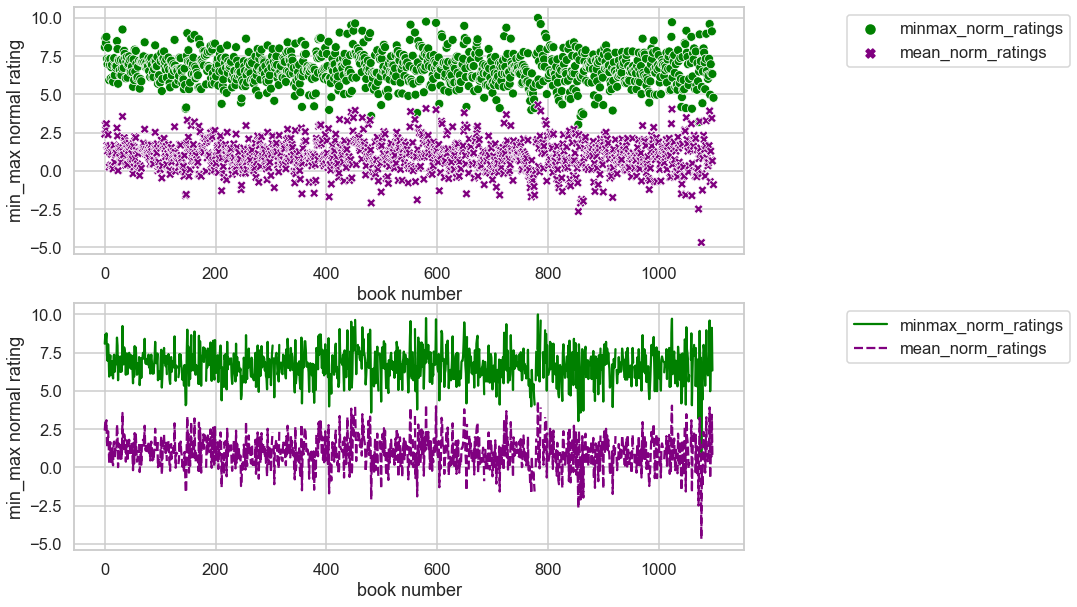

In [73]:
# 6 Create one graph that represents in the same figure both minmax_norm_rating and mean_norm_ratingdistributions.

#a = preprocessing()
#minmax_mean = a[['minmax_norm_ratings', 'mean_norm_ratings']]
#sns.relplot(data=minmax_mean); 

#pawas
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette(['green', 'purple'])
plt.figure(figsize=(12, 10))
a = preprocessing()
minmax_mean = a[['minmax_norm_ratings', 'mean_norm_ratings']]
plt.subplot(2,1,1)
ax=sns.scatterplot(data=minmax_mean);
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1));
ax.set(xlabel='book number', ylabel='min_max normal rating');
plt.subplot(2,1,2)
ax=sns.lineplot(data=minmax_mean);
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1));
ax.set(xlabel='book number', ylabel='min_max normal rating');

In [ ]:
# 7 What is the best fit in terms of a distribution (normal, chi-squared...) to represent each of those graphs?

In [82]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
#import statsmodels as sm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

w = preprocessing()
data = w["avg_ratings"].dropna()

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [83]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

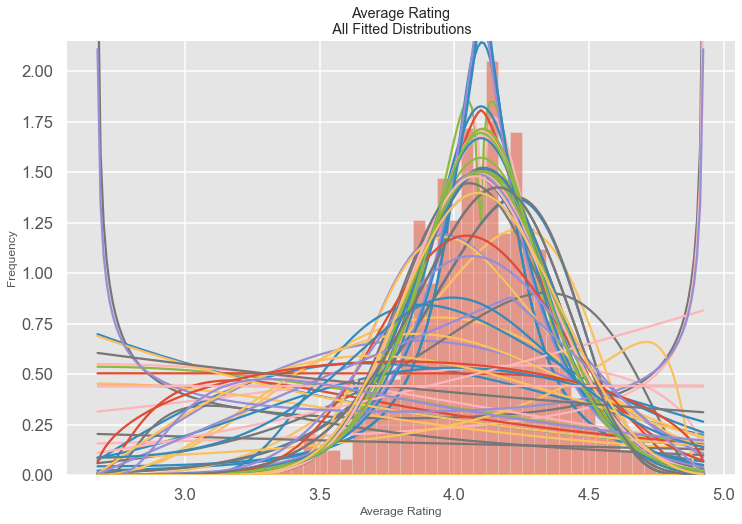

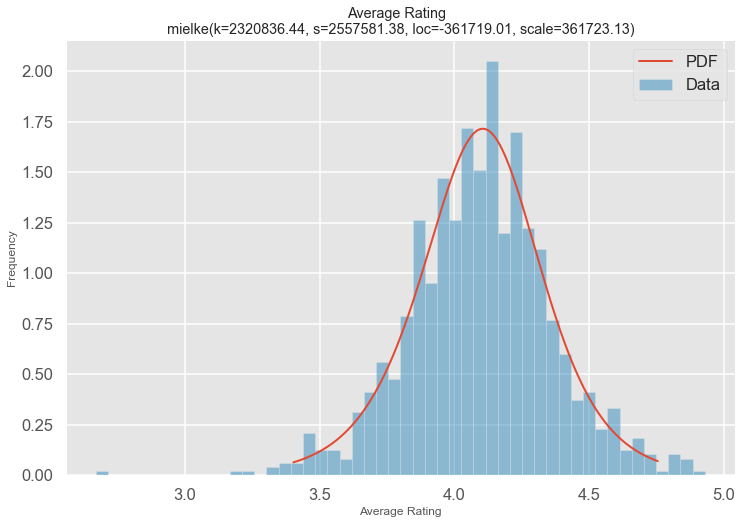

In [84]:
# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, alpha=0.5, density=True)
#sns.distplot(pdf, fit=norm, hist=True)

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Average Rating\n All Fitted Distributions')
ax.set_xlabel(u'Average Rating')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)

data.plot(kind='hist', bins=50, alpha=0.5, label='Data', legend=True,density=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Average Rating  \n' + dist_str)
ax.set_xlabel(u'Average Rating')
ax.set_ylabel('Frequency')
plt.legend()
plt.show()

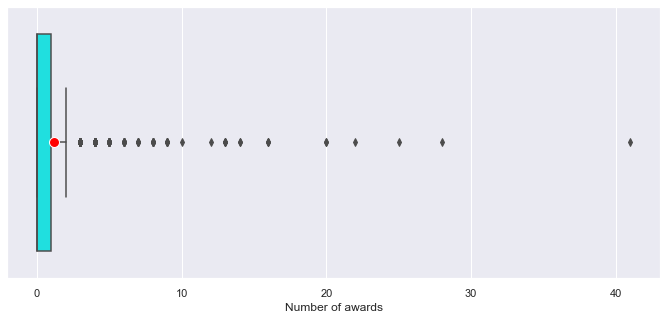

In [74]:
# 8 Visualize the awards distribution in a boxplot and aggregtated bars. 
#   Decide which of these representations gives us more information and in which cases they should be used.

sns.set(rc={'figure.figsize':(11.7,5.0)})

_= sns.boxplot(x=preprocessing()["award_count"],color='aqua', showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"white",
                      "markersize":"10"}, showfliers = True)
_= plt.xlabel('Number of awards');


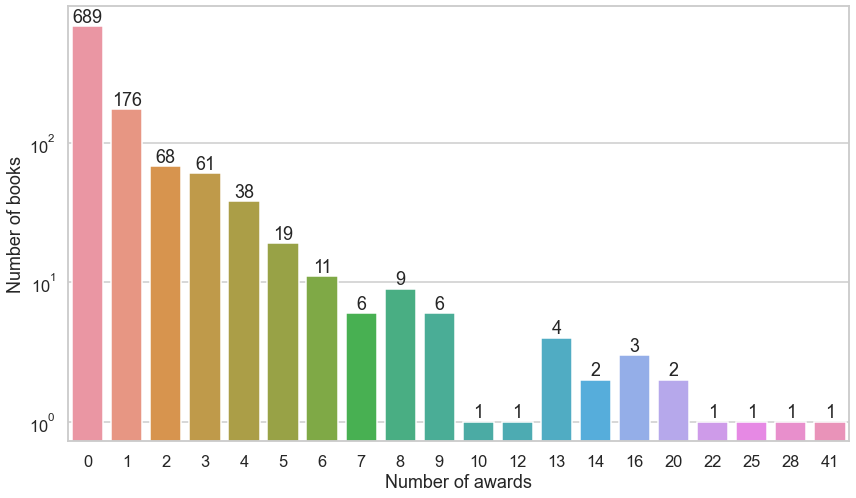

In [75]:
# 8 Visualize the awards distribution in a boxplot and aggregtated bars. 
#   Decide which of these representations gives us more information and in which cases they should be used

from matplotlib.ticker import MaxNLocator

dz = preprocessing()['award_count'].value_counts()
dw= dz.sort_index()
dw = pd.DataFrame(dw)
dw.reset_index(inplace=True)
dw = dw.rename(columns = {'index':'award_count', 'award_count': 'num_books'})

sns.set_context('talk')
sns.set_style('whitegrid')

plt.figure(figsize=(14, 8))
ax= sns.barplot(y=dw['num_books'],x=dw["award_count"])
ax.set_yscale("log")
for p in ax.patches:
    ax.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')


ax= plt.xlabel('Number of awards')
ax= plt.ylabel('Number of books')



In [76]:
df= preprocessing()
df_sorted = df.sort_values(by='award_count', ascending=False).head(10)
df_sorted['Title']

ID
360              The Hunger Games (The Hunger Games, #1)
221    Harry Potter and the Sorcerer's Stone (Harry P...
841                              Twilight (Twilight, #1)
842                                    Holes (Holes, #1)
895                                       The Book Thief
8                     Eragon (The Inheritance Cycle, #1)
27                       Graceling (Graceling Realm, #1)
678                            Seraphina (Seraphina, #1)
473                                   The Graveyard Book
935    The Lightning Thief (Percy Jackson and the Oly...
Name: Title, dtype: object

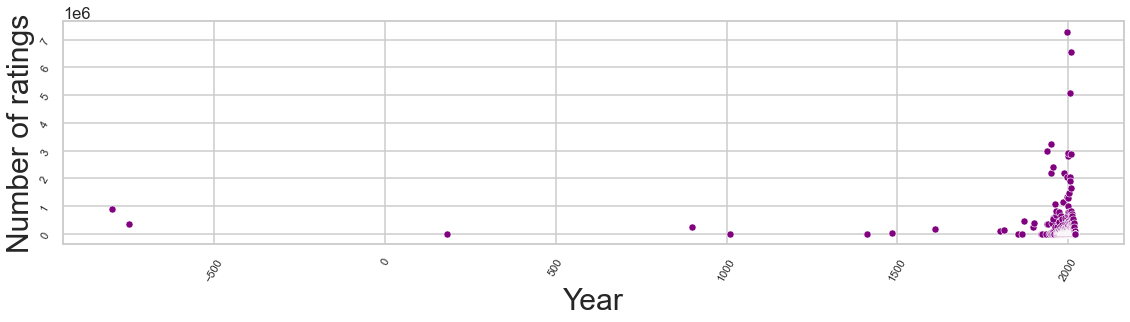

In [80]:
# 9 Now, make a simple plot to visualise the ratings w.r.t. the years!

new_df = preprocessing().dropna(subset=['number_of_ratings', 'original_publish_year'])
new_df['original_publish_year'] = new_df['original_publish_year'].astype(int) 
new_df.sort_values(by=['original_publish_year'],inplace=True)

df55=pd.DataFrame()
y=list(new_df['original_publish_year'])
r=list(new_df['number_of_ratings'])
df55['year']=y
df55['number_of_ratings']=r

sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette(['purple'])
plt.figure(figsize=(19, 9))
plt.subplot(2,1,1)
new_plt2=sns.scatterplot(y=df55["number_of_ratings"],x=df55["year"],s=50)
plt.xlabel("Year",size = 30)
plt.ylabel("Number of ratings",size = 30)
new_plt2.tick_params(labelsize=11,rotation=60)

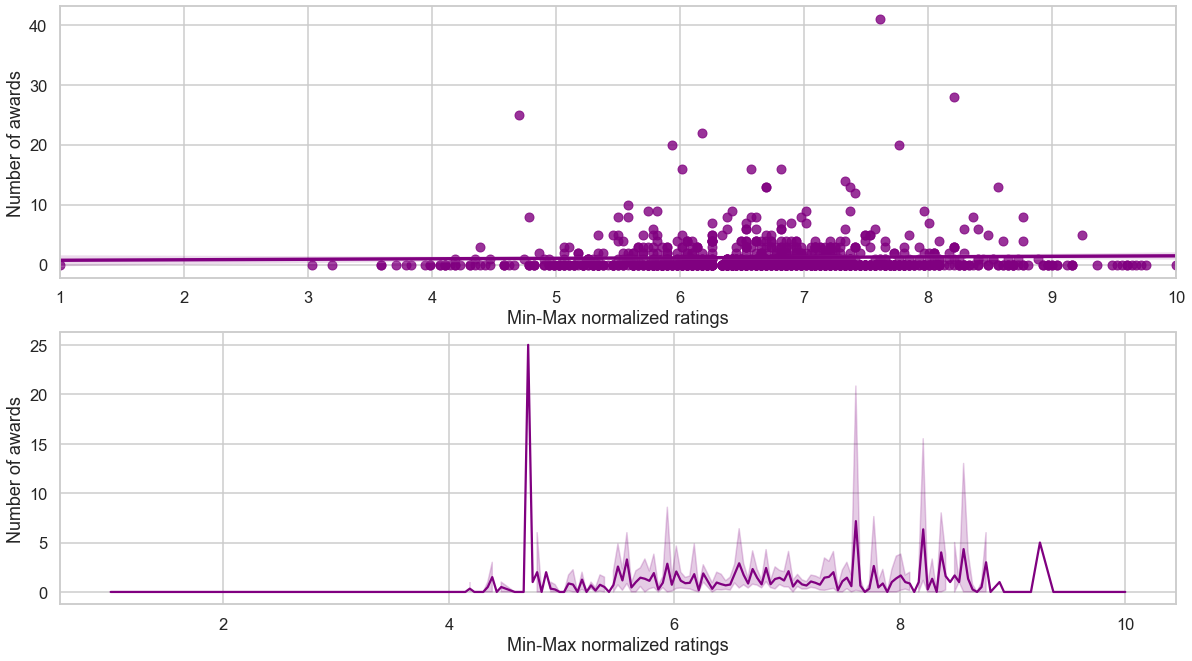

In [81]:
# 10. Make a scatterplot to represent minmax_norm_ratings in function of the number of awards won by the book.


sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette(['purple'])
plt.figure(figsize=(20, 11))
plt.subplot(2,1,2)
_= sns.lineplot(data=preprocessing(), x="minmax_norm_ratings", y="award_count")
_= plt.ylabel("Number of awards")
_= plt.xlabel("Min-Max normalized ratings")
plt.subplot(2,1,1)
_= sns.regplot(data=preprocessing(), x="minmax_norm_ratings", y="award_count")
_= plt.ylabel("Number of awards")
_= plt.xlabel("Min-Max normalized ratings")